# Harmonic persistent homology predicts lung cancer disease subtypes

Example code for Gurnari et al., "Probing omics data via harmonic persistent homology"

https://arxiv.org/abs/2311.06357

In [1]:
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import utils

## Load and process data

`add the data source`

In [2]:
df = pd.read_csv("data/TCGA_LUAD_TPM_expression_subtype.csv")
df.head()

,Unnamed: 0,patient_barcode,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,disease,expression_subtype
0,30,TCGA-05-4249,0.1841,0.0059,723.6305,0.1820,0.0553,35.9646,0.2228,28.6151,...,4.5565,13.6601,20.6886,1.0012,18.2084,118.4899,13.9766,16.2353,TCGA-LUAD,TRU
1,32,TCGA-05-4382,0.1252,0.0033,473.1468,0.2230,0.2753,25.6235,0.2111,22.0350,...,2.2365,7.0922,10.9247,2.1530,15.7320,250.4427,10.4197,11.3963,TCGA-LUAD,prox.-inflam
2,33,TCGA-05-4384,0.1920,0.0571,1346.6241,0.0307,0.2144,9.2104,0.2466,31.2066,...,5.9464,15.8912,23.3148,0.3972,18.3906,167.3500,21.0267,17.3986,TCGA-LUAD,TRU
3,34,TCGA-05-4389,0.0000,1.2842,182.0978,1.0241,0.0000,20.3936,0.2557,26.9433,...,4.5834,14.9202,14.0056,2.8209,10.7104,108.9233,6.8742,14.3967,TCGA-LUAD,prox.-prolif.
4,35,TCGA-05-4390,0.0731,0.0000,338.9284,0.0136,0.0000,35.4770,0.1096,26.6873,...,3.0339,16.8878,9.4842,0.6231,12.6524,225.5948,8.0873,10.1515,TCGA-LUAD,prox.-prolif.


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)

In [4]:
X = df[df.columns[2:-2]]
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

all_genes = X_scaled.columns.to_numpy()

NUM_GENES = 5000
max_var_genes = all_genes[np.argsort(X_scaled.var(axis=0).values)][::-1][:NUM_GENES]

X_max_var = X_scaled[max_var_genes]

X_max_var

,FTL,MT-CO1,MT-CO3,MT-CO2,SFTPB,MT-ND4,SFTPA2,SLPI,PGC,BPIFA1,...,ACSS1,RAB18,ABR,GSKIP,C5orf51,THOC6,C1GALT1,IRF3,LNX2,DHTKD1
0,-7739.965801,-541.188153,-5511.261805,-6643.586505,-3067.950914,-8139.882035,-1978.326677,-2855.00208,-2252.918396,-1977.025015,...,17.862894,6.279672,25.859638,10.445682,-9.811456,20.931719,-10.348512,19.266733,18.65615,-10.740198
1,8459.397999,-6024.621353,-5426.685105,-3574.511705,-8683.823114,-6154.939835,-6806.057077,-2936.87328,-2278.452596,-2016.771015,...,-7.332306,-3.029328,6.468238,-8.192618,-8.220056,-3.256981,14.472388,12.046233,-5.77515,-4.074598
2,3030.106699,6365.325647,338.284295,-1146.524905,11290.994386,-1951.192135,187.532323,-1465.87168,-792.575196,16197.149385,...,16.590394,3.602472,20.127538,3.064782,1.818744,1.957419,-6.756412,0.287333,27.10595,22.847302
3,47195.813799,-124.246953,-3254.466005,-3238.225605,-5968.847614,-4852.247135,-6671.538777,-2100.85898,-1959.116696,-2001.238315,...,11.443194,-0.756528,-1.536462,4.465082,-6.035656,-11.272481,-2.420212,1.665133,-12.16345,14.439502
4,-7250.791301,-7270.042853,-3253.789205,-5678.164505,2479.084286,-8075.281435,-6261.273477,-3032.61268,-1043.378296,34662.491285,...,-8.347006,3.085572,-6.100362,36.928082,-11.772456,33.667519,-11.467512,7.424233,30.45415,-5.886298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,-8541.426201,-6563.320053,-6453.192405,-1297.776605,-4252.810414,-4314.168335,-3762.342777,-2897.97268,-2270.929196,-2014.024015,...,-12.650306,-7.546528,1.087538,-3.614118,6.656044,-9.887081,0.387388,-9.915367,-13.65875,5.378002
226,-8572.182201,24621.162847,30897.809495,13140.066695,-7039.371014,14139.501865,-6807.364877,-2902.62628,-2267.980996,-2019.360515,...,12.291394,40.184872,-15.058762,-4.349418,18.770444,8.520619,23.240988,-1.153767,13.83655,11.960502
227,-7499.215401,-1584.591053,-2123.591905,-6293.761505,6749.904386,-1094.936035,-3899.122877,-754.91638,-2218.076196,-2019.601315,...,12.519594,13.162572,-11.988462,-9.347918,20.587144,-11.833081,3.065988,-19.181067,30.79185,2.223002
228,-5537.019401,19052.056147,10525.838795,15915.568095,-2758.611914,8183.506265,-3154.081277,-1235.68798,-2153.192496,-2022.014915,...,27.190494,-13.458728,32.376038,-17.754518,-12.424856,-4.554781,-5.983612,14.197533,-4.24565,-10.357998


In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

y = df.loc[:, ["expression_subtype"]].copy()
y["label"] = le.fit_transform(y.expression_subtype)
y

,expression_subtype,label
0,TRU,0
1,prox.-inflam,1
2,TRU,0
3,prox.-prolif.,2
4,prox.-prolif.,2
...,...,...
225,prox.-inflam,1
226,prox.-inflam,1
227,TRU,0
228,TRU,0


In [6]:
y.expression_subtype.value_counts()

expression_subtype
TRU              89
prox.-inflam     78
prox.-prolif.    63
Name: count, dtype: int64

In [7]:
print(X.shape, X_max_var.shape, y.shape)

(230, 19938) (230, 5000) (230, 2)


## PCA

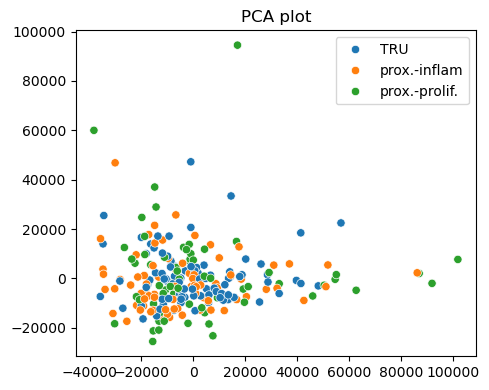

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_max_var)

plt.figure(figsize=(5, 4))

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y.expression_subtype)
plt.legend().set_title(None)
plt.title("PCA plot")
plt.tight_layout()

## Harmonics pipeline

In [9]:
import harmonics

computing distance matrix
(5000, 5000)


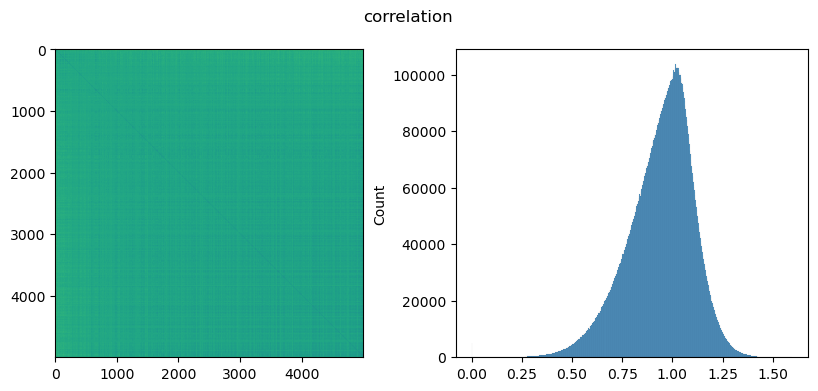

complex created 0.20s
5000 0-dim simplices
9997 1-dim simplices
45557 2-dim simplices
0 3-dim simplices
computing homology
done 0.34s


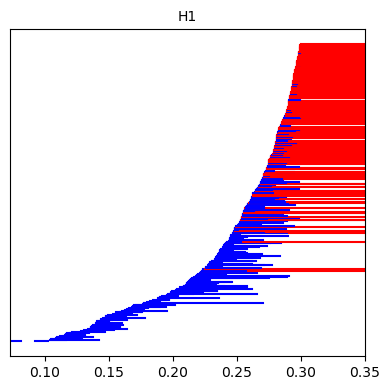

there are 513 1-dimensional bars
computing harmonics
using the column reduced boundary matrix
no cycles selected, projecting all 513 1-dimensional cycles
precomputing boundary matrix
B shape (9996, 7606). Q shape (9996, 7606). 28.405s


  0%|          | 0/513 [00:00<?, ?it/s]

done 68.52s


In [10]:
# harmonic weights on the genes
weights_GENES = harmonics.extract_harmonic_weights(
    X_max_var.T, upper_bound=0.3, metric="correlation", output_file="genes.pkl"
)

In [12]:
weights_GENES = pd.read_pickle("genes.pkl")

In [13]:
weights_GENES

,birth,death,bar_length,FTL,MT-CO1,MT-CO3,MT-CO2,SFTPB,MT-ND4,SFTPA2,...,ACSS1,RAB18,ABR,GSKIP,C5orf51,THOC6,C1GALT1,IRF3,LNX2,DHTKD1
bar_id,,,,,,,,,,,,,,,,,,,,,
8792,0.177587,0.270538,0.092951,0.0,3.000905e-17,4.277108e-17,4.972293e-17,0.0,3.541820e-17,6.899477e-19,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
17217,0.222705,inf,0.077295,0.0,1.550332e-17,4.519589e-18,2.867138e-17,0.0,4.519589e-18,8.170599e-32,...,0.0,0.0,0.0,0.000000e+00,2.132047e-33,0.0,0.0,0.0,0.0,0.0
17829,0.224822,inf,0.075178,0.0,2.394054e-16,2.293778e-16,1.671364e-16,0.0,2.094387e-16,3.238909e-17,...,0.0,0.0,0.0,0.000000e+00,4.548807e-18,0.0,0.0,0.0,0.0,0.0
15535,0.216406,0.289041,0.072635,0.0,8.523827e-17,6.617019e-17,1.218330e-16,0.0,1.025608e-16,1.622921e-16,...,0.0,0.0,0.0,0.000000e+00,1.986455e-21,0.0,0.0,0.0,0.0,0.0
16063,0.218311,0.290528,0.072217,0.0,1.450723e-16,1.113952e-16,1.208595e-16,0.0,1.686075e-16,3.274553e-17,...,0.0,0.0,0.0,0.000000e+00,3.190324e-18,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33142,0.263200,0.263297,0.000097,0.0,9.499390e-17,1.206808e-16,8.051165e-17,0.0,1.341009e-16,5.921101e-18,...,0.0,0.0,0.0,0.000000e+00,1.001151e-17,0.0,0.0,0.0,0.0,0.0
9967,0.187096,0.187136,0.000040,0.0,6.879062e-17,4.074874e-17,5.773696e-17,0.0,2.957489e-17,9.640817e-18,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
60548,0.299977,inf,0.000023,0.0,1.856800e-16,2.151843e-16,2.102813e-16,0.0,2.163517e-16,9.704100e-17,...,0.0,0.0,0.0,1.252920e-18,1.868464e-03,0.0,0.0,0.0,0.0,0.0


In [14]:
weight_gene_df = copy.deepcopy(weights_GENES)
idx_birth = weight_gene_df.sort_values(["birth"]).index
top_idx = list(idx_birth[:100])
weight_gene_df = weight_gene_df.loc[weight_gene_df.index.isin(top_idx)]
weight_gene_df = weight_gene_df.sort_values("bar_length", ascending=False)[:30]
weight_gene_df.shape

(30, 5003)

# Classification

select the model you want to train by in `ML_pipeline.py` 

In [15]:
import ML_pipeline
import operator

In [16]:
from sklearn.metrics import (
    auc,
    roc_curve,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X_max_var,
    y.label,
    X_max_var.index.to_numpy(),
    test_size=0.2,
    random_state=5,
    stratify=y,
)
print(X_train.shape, X_test.shape)

(184, 5000) (46, 5000)


### Baseline: Train on original features

In [27]:
result = []

all_grids = ML_pipeline.ml_pipeline(use_scaler=False)
for pipe in all_grids:
    pipe.fit(X_train, y_train)

    result.append(
        {
            "grid": pipe,
            "classifier": pipe.best_estimator_,
            "best score": pipe.best_score_,
            "best params": pipe.best_params_,
            "cv": pipe.cv,
        }
    )

no scaler
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [28]:
# sorting result by best score
result = sorted(result, key=operator.itemgetter("best score"), reverse=True)

print(" Training Performance \n  ")
for m in result:
    print(m["classifier"], m["best score"])

 Training Performance 
  
Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=70,
            

[Text(0, 0, 'TRU'), Text(0, 1, 'prox.-inflam'), Text(0, 2, 'prox.-prolif.')]

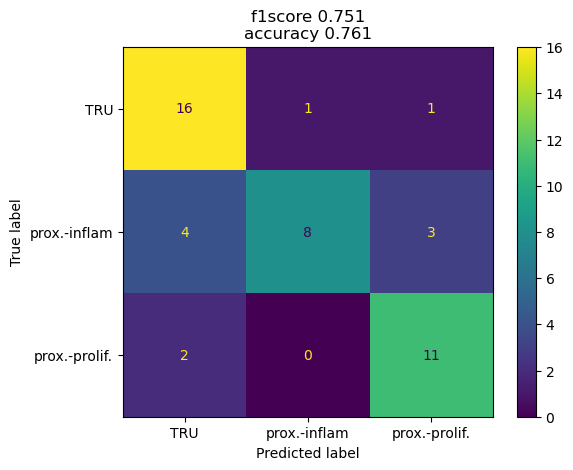

In [29]:
# evaluate model
model = result[0]["classifier"]
y_pred = model.predict(X_test)

fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize=None, ax=ax)
plt.title(
    "f1score {:.3f}\naccuracy {:.3}".format(
        f1_score(y_test, model.predict(X_test), average="macro"),
        accuracy_score(y_test, model.predict(X_test)),
    )
)
ax.xaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))
ax.yaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))

### Option 2: use harmonic weights to scale the original features

In [30]:
total_weights = weight_gene_df[weight_gene_df.columns[3:]].sum(axis=0)
total_weights

FTL        0.000000e+00
MT-CO1     1.186565e-15
MT-CO3     1.500123e-15
MT-CO2     1.594034e-15
SFTPB      0.000000e+00
               ...     
THOC6      0.000000e+00
C1GALT1    0.000000e+00
IRF3       0.000000e+00
LNX2       0.000000e+00
DHTKD1     0.000000e+00
Length: 5000, dtype: float64

In [31]:
X_HW_train = X_train * total_weights
X_HW_test = X_test * total_weights

X_HW_train.shape

(184, 5000)

In [35]:
HW_result = []

HW_all_grids = ML_pipeline.ml_pipeline(use_scaler=True)
for pipe in HW_all_grids:
    pipe.fit(X_HW_train, y_train)

    HW_result.append(
        {
            "grid": pipe,
            "classifier": pipe.best_estimator_,
            "best score": pipe.best_score_,
            "best params": pipe.best_params_,
            "cv": pipe.cv,
        }
    )

# sorting result by best score
HW_result = sorted(HW_result, key=operator.itemgetter("best score"), reverse=True)

print(" Training Performance \n  ")
for m in HW_result:
    print(m["classifier"], m["best score"])

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Training Performance 
  
Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi

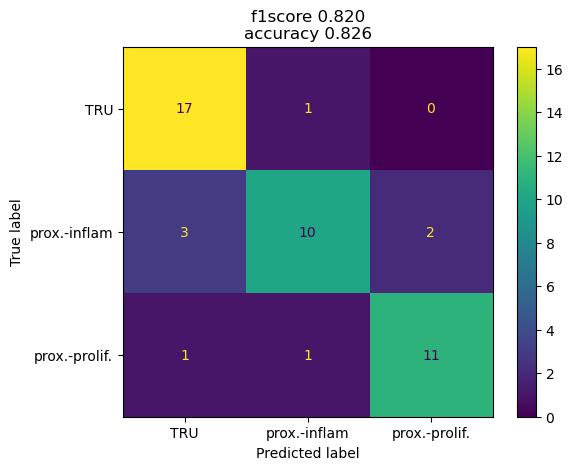

In [36]:
# evaluate model
HW_model = HW_result[0]["classifier"]
y_pred = HW_model.predict(X_HW_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(
    HW_model, X_HW_test, y_test, normalize=None, ax=ax
)
plt.title(
    "f1score {:.3f}\naccuracy {:.3}".format(
        f1_score(y_test, HW_model.predict(X_HW_test), average="macro"),
        accuracy_score(y_test, HW_model.predict(X_HW_test)),
    )
)

ax.xaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))
ax.yaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))
plt.show()

## Model comparison

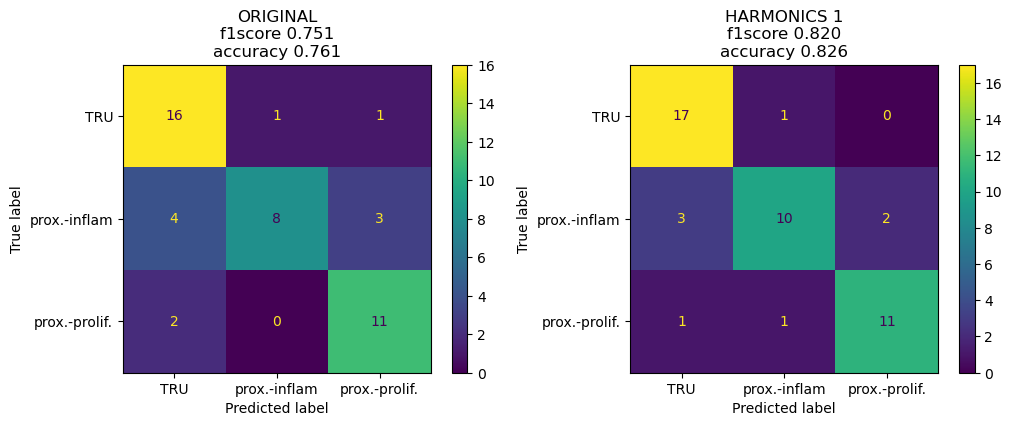

In [41]:
## Comparison

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize=None, ax=axs[0])
axs[0].set_title(
    "ORIGINAL\nf1score {:.3f}\naccuracy {:.3}".format(
        f1_score(y_test, model.predict(X_test), average="macro"),
        accuracy_score(y_test, model.predict(X_test)),
    )
)

ConfusionMatrixDisplay.from_estimator(
    HW_model, X_HW_test, y_test, normalize=None, ax=axs[1]
)
axs[1].set_title(
    "HARMONICS 1\nf1score {:.3f}\naccuracy {:.3}".format(
        f1_score(y_test, HW_model.predict(X_HW_test), average="macro"),
        accuracy_score(y_test, HW_model.predict(X_HW_test)),
    )
)

for ax in axs:
    ax.xaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))
    ax.yaxis.set_ticklabels(le.inverse_transform([0, 1, 2]))

plt.show()